In [1]:
# imports
import os
import sys
from pixell import enmap, pointsrcs, enplot, utils
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
from pysm3 import units as u

In [2]:
fwhm = 1 * u.deg
from pysm3.models.catalog import *

In [3]:
shape, wcs = enmap.fullsky_geometry(res=(0.1 * u.deg).to_value(u.rad))

In [4]:
fluxes_I = np.ones(1)*10*u.Jy

In [5]:
scaling_factor = 1 * u.uK_RJ / (u.Jy/u.sr)

In [6]:
output_map = enmap.enmap(np.zeros(shape, dtype=np.float32), wcs)
r, p = pointsrcs.expand_beam(fwhm2sigma(fwhm.to_value(u.rad)))
output_map = (
    pointsrcs.sim_objects(
        shape,
        wcs,
        np.array([[0],[0]]),
        flux2amp(np.array([10]), fwhm.to_value(u.rad))
        * scaling_factor.value,  # to peak amplitude and to output units
        ((r, p))))

In [7]:
flux2amp(np.array([10]), fwhm.to_value(u.rad))

array([28972.15796879])

In [8]:
output_map.max()

array(28972.158, dtype=float32)

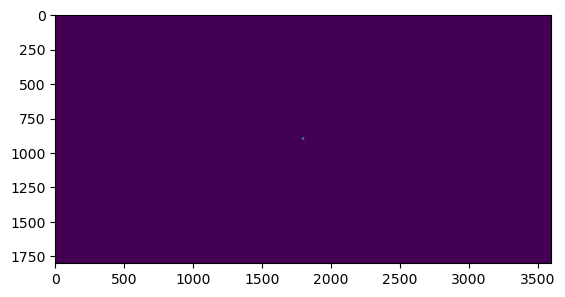

In [9]:
plt.imshow(output_map)

In [10]:
output_map.argmax(unit="pixel")

array([ 900, 1800])

In [11]:
enmap.pixsizemap(shape, wcs)[180, 360]

9.413194754914742e-07

In [12]:
output_map[180, 360] * enmap.pixsizemap(shape, wcs)[180, 360]

0.0

In [13]:
from pysm3.utils import car_aperture_photometry

In [14]:
box_half_size_rad = 2 * fwhm.to_value(u.rad)
box_center = [0, 0]
box = np.array(
    [
        [box_center[0] - box_half_size_rad, box_center[1] - box_half_size_rad],
        [box_center[0] + box_half_size_rad, box_center[1] + box_half_size_rad],
    ]
)  # in radians
cutout = output_map.submap(box)
flux = car_aperture_photometry(cutout, 2 * fwhm.to_value(u.rad))

In [15]:
flux

9.998954563795008

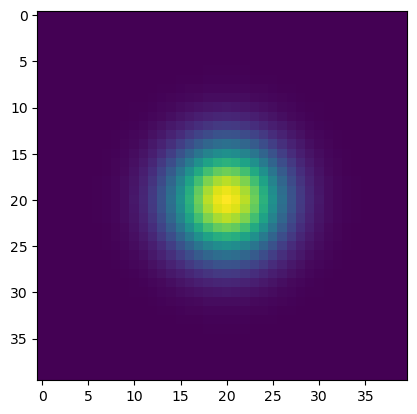

In [16]:
plt.imshow(cutout)

In [17]:
cutout.max()

array(28972.158, dtype=float32)

In [18]:
output_map.to_healpix(nside=128)

/home/zonca/micromamba/envs/pysm/lib/python3.11/site-packages/pixell/enmap.py:2263: UserWarning: enmap.to_healpix is deprecated. Reprojecting this way is error-prone due to the potential loss of information, and the (very small) loss of high-l power due to the use of spline interpolation. Use reproject.map2healpix instead. And read its docstring!
  warnings.warn("enmap.to_healpix is deprecated. Reprojecting this way is error-prone due to the potential loss of information, and the (very small) loss of high-l power due to the use of spline interpolation. Use reproject.map2healpix instead. And read its docstring!")


array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [19]:
from pixell import reproject

In [20]:
reproject.map2healpix?

Signature:
reproject.map2healpix(
    imap,
    nside=None,
    lmax=None,
    out=None,
    rot=None,
    spin=[0, 2],
    method='harm',
    order=1,
    extensive=False,
    bsize=100000,
    nside_mode='pow2',
    boundary='constant',
    verbose=False,
    niter=0,
)
Docstring:
Reproject from an enmap to healpix, optionally including a rotation.

imap:  The input enmap[...,ny,nx]. Stokes along the -3rd axis if
       present.
nside: The nside of the healpix map to generate. Not used if
       an output map is passed. Otherwise defaults to the same
       resolution as the input map.
lmax:  The highest multipole to use in any harmonic-space
       operations. Defaults to the input maps' Nyquist limit.
out:   An optional array [...,npix] to write the output map to.
       The ...  part must match the input map, as must the data
       type.
rot:   An optional coordinate rotation to apply. Either a string
       "isys,osys", where isys is the system to transform from,
       and osys